In [78]:
import numpy as np
import time
import winsound
import pickle
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from subscale_explorer import SubscaleExplorer

In [ ]:
# procedure without helper funktion explore()
sub = SubscaleExplorer()
sub.generate_database(n=1000, d=200, c=10, sub_n=20, sub_d=10, std=0.1)
sub.subscale(epsilon=0.3, minpts=5)
sub.dbscan(eps=0.3, min_samples=10, adjust_epsilon=True)
sub.score("ce")

In [5]:
def explore(verbose=True, **setting):
    sub = SubscaleExplorer()
    stats = []
    for n, d in itertools.product(settings["n"], settings["d"]):
        sub.generate_database(n=n, d=d, c=settings["c"],
                      sub_n=settings["sub_n"], sub_d=settings["sub_d"], std=settings["std"])
        for eps_subscale, minpts_subscale in itertools.product(settings["eps_subscale"], settings["minpts_subscale"]):
            ts = time.time()
            sub.subscale(epsilon=eps_subscale, minpts=minpts_subscale)
            winsound.Beep(220, 100)
            t1 = time.time() - ts
            for eps_dbscan, minpts_dbscan, adj in itertools.product(settings["eps_dbscan"],
                                                                    settings["minpts_dbscan"],
                                                                    settings["adj"]):
                ts = time.time()
                sub.dbscan(eps=eps_dbscan, min_samples=minpts_dbscan, adjust_epsilon=adj)
                winsound.Beep(440, 100)
                t2 = time.time() - ts
                scores = {metric:score for (metric, score) in zip(settings["metrics"],
                                                         [sub.score(metric) for metric in settings["metrics"]])}
                winsound.Beep(880, 100)
                tmp = { "eps_subscale": eps_subscale, "minpts_subscale": minpts_subscale,
                       "eps_dbscan": eps_dbscan, "minpts_dbscan": minpts_dbscan, "n":n, "d":d, "adj":adj,
                        "scores": scores, "duration_subscale": t1, "duration_dbscan":t2,}
                if verbose:
                    print(tmp)
                stats.append(tmp)
    result = {"settings": settings, "stats": stats}
    return result

### Auswirkung der Anzahl Punkten auf die Laufzeit
Antwort: Schwer zu sagen

In [ ]:
settings =  {"n":[500, 1000, 2000, 4000],
             "d":[200],
             "c":10,
             "sub_n":10,
             "sub_d": 10,
             "std":0.1,
             "eps_subscale": [0.3],
             "minpts_subscale":[3],
             "eps_dbscan":[0.3],
             "minpts_dbscan":[5],
             "adj":[True],
             "metrics": ["ce"]}
stats = explore(**settings)

<AxesSubplot:xlabel='n', ylabel='duration'>

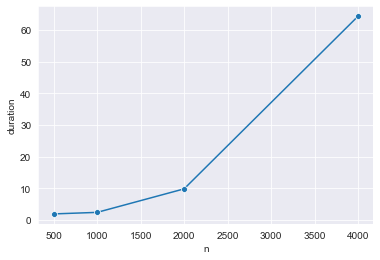

In [20]:
stats["duration"] = stats["duration_subscale"] + stats["duration_dbscan"]
sns.lineplot(data=stats, x="n", y="duration", marker="o")


### Was ist der beste Wert für Epsilon wenn die Standardverteilung gegeben ist?
Antwort: ungefähr Faktor 3 bezogen auf die Standardverteilung

In [6]:
settings =  {"n":[1000], "d":[200], "c":10, "sub_n":50, "sub_d":10, "std":0.1,
             "eps_subscale": [0.15, 0.3, 0.6], "minpts_subscale":[3],
             "eps_dbscan":[0.01, 0.1, 1], "minpts_dbscan":[5], "adj":[True],
             "metrics": ["ce"]}
res = explore(**settings)
stats = pd.DataFrame(res["stats"])

{'eps_subscale': 0.15, 'minpts_subscale': 3, 'eps_dbscan': 0.01, 'minpts_dbscan': 5, 'n': 1000, 'd': 200, 'adj': True, 'scores': {'ce': 0.0023999999999999577}, 'duration_subscale': 6.145869731903076, 'duration_dbscan': 3.4991648197174072}
{'eps_subscale': 0.15, 'minpts_subscale': 3, 'eps_dbscan': 0.1, 'minpts_dbscan': 5, 'n': 1000, 'd': 200, 'adj': True, 'scores': {'ce': 0.44220000000000004}, 'duration_subscale': 6.145869731903076, 'duration_dbscan': 3.855441093444824}
{'eps_subscale': 0.15, 'minpts_subscale': 3, 'eps_dbscan': 1, 'minpts_dbscan': 5, 'n': 1000, 'd': 200, 'adj': True, 'scores': {'ce': 0.44220000000000004}, 'duration_subscale': 6.145869731903076, 'duration_dbscan': 4.677390098571777}
{'eps_subscale': 0.3, 'minpts_subscale': 3, 'eps_dbscan': 0.01, 'minpts_dbscan': 5, 'n': 1000, 'd': 200, 'adj': True, 'scores': {'ce': 0}, 'duration_subscale': 7.05513334274292, 'duration_dbscan': 3.569469451904297}
{'eps_subscale': 0.3, 'minpts_subscale': 3, 'eps_dbscan': 0.1, 'minpts_dbscan

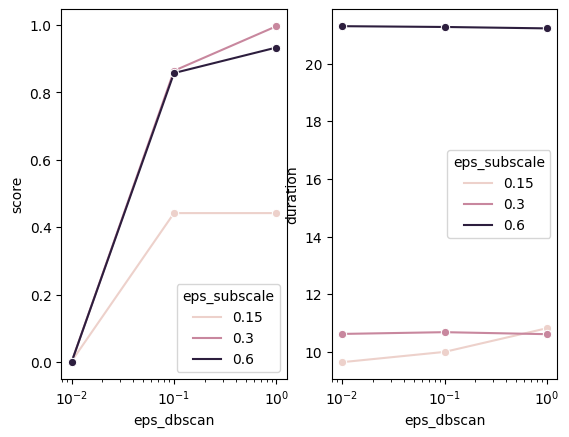

In [7]:
f, axs = plt.subplots(1,2)

stats["score"] = stats["scores"].apply(lambda x: x["ce"])
sns.lineplot(data=stats, x="eps_dbscan", y="score", hue="eps_subscale", marker="o", ax=axs[0])
axs[0].set_xticks([0.01, 0.1, 1])
axs[0].set(xscale="log")

stats["duration"] = stats["duration_subscale"] + stats["duration_dbscan"]
sns.lineplot(data=stats, x="eps_dbscan", y="duration", hue="eps_subscale", marker="o", ax=axs[1])
axs[1].set_xscale("log")

# plt.savefig("epsilon.eps", format="eps")
plt.show()

### Funktioniert Autoadjust von Epsilon bei DBASCAN?
Antwort: Ja, sehr gut

In [59]:
settings =  {"n":[2000], "d":[200], "c":15, "sub_n":10,
             "sub_d":[10, 10, 10, 10, 10, 20, 20, 20, 20, 15, 30, 30, 30, 30, 30], "std":0.1,
             "eps_subscale": [0.4], "minpts_subscale":[3],
             "eps_dbscan":[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], "minpts_dbscan":[5], "adj":[True, False],
             "metrics": ["ce", "f1", "rnia"]}
res = explore(**settings)
stats = pd.DataFrame(res["stats"])

{'eps_subscale': 0.4, 'minpts_subscale': 3, 'eps_dbscan': 0.1, 'minpts_dbscan': 5, 'n': 2000, 'd': 200, 'adj': True, 'scores': {'ce': 0.1321260898725688, 'f1': 0.8424708830900782, 'rnia': 0.329979879275654}, 'duration_subscale': 14.763914585113525, 'duration_dbscan': 7.867908000946045}
{'eps_subscale': 0.4, 'minpts_subscale': 3, 'eps_dbscan': 0.1, 'minpts_dbscan': 5, 'n': 2000, 'd': 200, 'adj': False, 'scores': {'ce': 0.053981106612685514, 'f1': 0.6183178534571724, 'rnia': 0.14304993252361675}, 'duration_subscale': 14.763914585113525, 'duration_dbscan': 9.7890784740448}
{'eps_subscale': 0.4, 'minpts_subscale': 3, 'eps_dbscan': 0.2, 'minpts_dbscan': 5, 'n': 2000, 'd': 200, 'adj': True, 'scores': {'ce': 0.9531502423263328, 'f1': 1.0, 'rnia': 0.9531502423263328}, 'duration_subscale': 14.763914585113525, 'duration_dbscan': 12.07809066772461}
{'eps_subscale': 0.4, 'minpts_subscale': 3, 'eps_dbscan': 0.2, 'minpts_dbscan': 5, 'n': 2000, 'd': 200, 'adj': False, 'scores': {'ce': 0.0809649702577

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


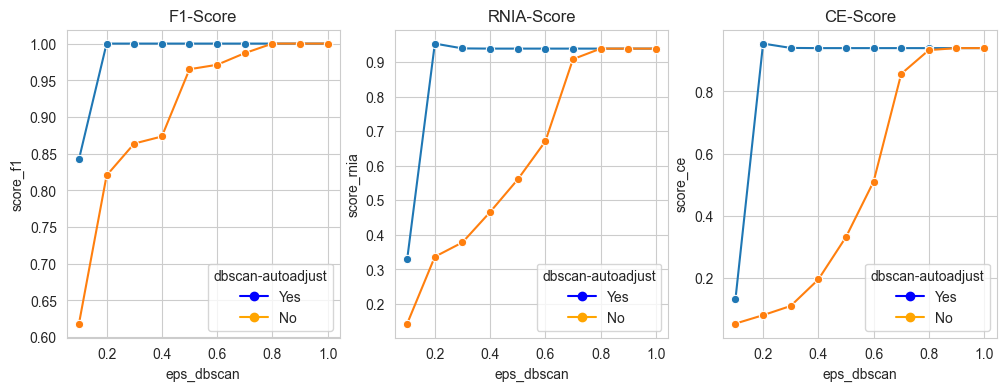

In [80]:
f, axs = plt.subplots(1,3, figsize=(12,4))
stats["score_f1"] = stats["scores"].apply(lambda x: x["f1"])
sns.lineplot(data=stats[stats["adj"]==True], x="eps_dbscan", y="score_f1", style="eps_subscale", marker="o", ax=axs[0])
sns.lineplot(data=stats[stats["adj"]==False], x="eps_dbscan", y="score_f1", style="eps_subscale", marker="o", ax=axs[0])
axs[0].set_title("F1-Score")

stats["score_rnia"] = stats["scores"].apply(lambda x: x["rnia"])
sns.lineplot(data=stats[stats["adj"]==True], x="eps_dbscan", y="score_rnia", style="eps_subscale", marker="o", ax=axs[1])
sns.lineplot(data=stats[stats["adj"]==False], x="eps_dbscan", y="score_rnia", style="eps_subscale", marker="o", ax=axs[1])
axs[1].set_title("RNIA-Score")

stats["score_ce"] = stats["scores"].apply(lambda x: x["ce"])
sns.lineplot(data=stats[stats["adj"]==True], x="eps_dbscan", y="score_ce", style="eps_subscale", marker="o", ax=axs[2])
sns.lineplot(data=stats[stats["adj"]==False], x="eps_dbscan", y="score_ce", style="eps_subscale", marker="o", ax=axs[2])
axs[2].set_title("CE-Score")

legend_colors = [Line2D([0], [0], color="blue", marker="o"),
               Line2D([0], [0], color="orange", marker="o")]
for i in range(len(axs)):
    axs[i].legend(handles=legend_colors, title='dbscan-autoadjust', labels=['Yes', 'No'])


#plt.savefig("autoadjust.eps", format="eps")


### Wie ist min_pts bei Subscale zu wählen?
Antwort: Am besten wählt man für Epsilon den Wert 2 oder 3. Bei Epsilon=2 konnten teilweise die besten Scorings erzielt werden,
wobei dadurch auch die Laufzeit von DBSCAN stark angestiegen ist.
Bei Epsilon=4 stieg die Laufzeit von Subscale stark an, ohne dass bessere Clusterings gefunden wurden.

In [ ]:
settings =  {"n":[1000], "d":[200], "c":10, "sub_n":10, "sub_d":10, "std":0.01,
             "eps_subscale": [0.03], "minpts_subscale":[2,3,4,5],
             "eps_dbscan":[0.03], "minpts_dbscan":[5], "adj":[False],
             "metrics": ["ce", "f1", "rnia"]}
res = explore(**settings)
pd.DataFrame(res["stats"])
# größeres minpts_sublscale schlechteres ergebnis.

In [ ]:
settings =  {"n":[10000], "d":[200], "c":10, "sub_n":50, "sub_d":10, "std":0.01,
             "eps_subscale": [0.03], "minpts_subscale":[2,3,4,5],
             "eps_dbscan":[0.03], "minpts_dbscan":[5], "adj":[False],
             "metrics": ["ce", "f1", "rnia"]}
res = explore(**settings)
pd.DataFrame(res["stats"])
# alle scores waren gleich. Nur Laufzeit ging rasant hoch.